# Suojakaistan testaus ja kehittäminen jupyter-sovelluksessa

## Tuodaan tarvittavat moduulit, sovellusympäristö ja globaalit

In [1]:
from osgeo import gdal,gdal_array
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests,tempfile,os,collections
from time import localtime, strftime
import numpy as np
import sys,subprocess
import pandas as pd
from math import sqrt,pow

from qgis.core import *
from qgis.analysis import QgsNativeAlgorithms
from qgis.PyQt.QtCore import QVariant

from whitebox.whitebox_tools import WhiteboxTools

In [2]:
QgsApplication.setPrefixPath(r'C:\OSGeo4W\apps\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')

import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())

wbt = WhiteboxTools()

<AxesSubplot:>

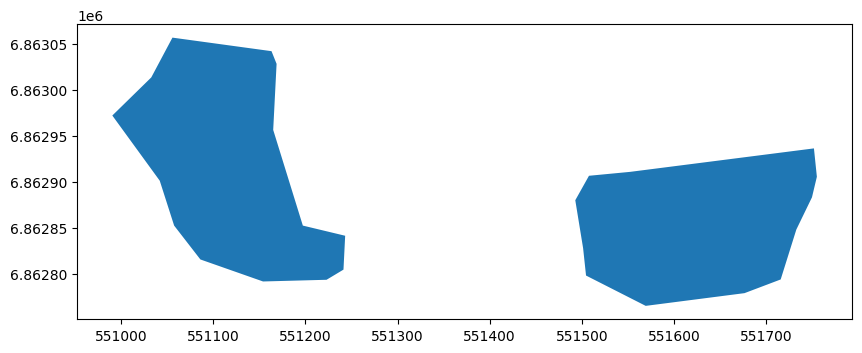

In [3]:
#parametrit
source =r"S:/Luontotieto/QGIS_plugin_test/testitasot.gpkg"
layername="suojakaistaLeim"
testitaso = r'S:/Luontotieto/QGIS_plugin_test/testitasot.gpkg|layername=suojakaistaLeim'
testitaso = QgsVectorLayer(testitaso,"input","ogr")
pnimet = ['suojakaista_taustarasterit','RUSLE','MassataseGISSUS','WB_Finland','DEM','D8_suomi'] #taustarastereissa band1 = costdistance ; band2 = euclidean ; band3 = lsn
mindist = 10
avgdist = 20

output =  r'S:/Luontotieto/QGIS_plugin_test/testitasot.gpkg'
#testataan miltä testiaineisto näyttää
fig,ax = plt.subplots(figsize=(10,10))
gpd.read_file(source,layer=layername).plot(ax=ax)

## Aineiston hakuun rajapinnasta liittyvät toiminnot

In [4]:
def getBboxWmsFormat(in_feat):
    desc=in_feat.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(in_feat.crs().authid())
    exte = str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)
    witdth = x_max - x_min
    height = y_max - y_min
    
    return exte,srid,witdth,height

In [5]:
def getWater(input_polygon,taso):
    #tempd = tempfile.TemporaryFile()
    #os.makedirs(tempd.name)
    #tempd = tempd.name+'.tif'
    tempd = os.path.dirname(os.path.realpath(input_polygon.sourceName()))
    tempd = os.path.join(tempd,str(taso)+'.tif')
    #tempd = tempd.name+str(taso)+'.tif'
    bbox = getBboxWmsFormat(input_polygon)
    #print (bbox)
    ss = bbox[0].split(',')
    #print (ss)
    wmsurl = 'https://aineistot.metsakeskus.fi/metsakeskus/rest/services/Vesiensuojelu/'+taso+'/ImageServer/exportImage?'
    params = {"bbox":str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1)),
                "bboxSR":3067,
                "size":str((round(int(ss[2])+100,-1)-round(int(ss[0])-100,-1))/2)+","+str((round(int(ss[3])+100,-1) - round(int(ss[1])-100,-1))/2),
                "imageSR":3067,
                "format":'tiff',
                "pixelType":"F32",
                "noData":-9999,
                "noDataInterpretation":"esriNoDataMatchAny",
                "interpolation":"+RSP_BilinearInterpolation",
                "f":"image"}

    #print (params)
    #print (str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1))+" ")
    test = requests.get(wmsurl,params,allow_redirects=True)
    respo = test.content
    f = open(tempd,"wb")
    f.write(respo)
    f.close()
    
    return tempd

In [6]:
def showRaster(raster):
    ds = gdal.Open(raster)
    gt = ds.GetGeoTransform()
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    data = ds.ReadAsArray()
    ds = None
    try:
        data = np.ma.masked_values(data, nodata)
    except:
        data = np.ma.masked_values(data,-9999)
    ys, xs = data.shape
    ulx, xres, _, uly, _, yres = gt
    extent = [ulx, ulx+xres*xs, uly, uly+yres*ys]

    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True, facecolor='w', dpi=86)

    cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis
    cmap.set_bad('#dddddd')

    im = ax.imshow(data, extent=extent, cmap=cmap)
    cb = fig.colorbar(im, shrink=.5)
    cb.set_label('Bathymetry [m]')

### Haetaan tausta-aineistot ja testataan että kaikki näyttää hyvälle

['C:\\OSGeo4W\\notebooks\\suojakaista_taustarasterit.tif', 'C:\\OSGeo4W\\notebooks\\RUSLE.tif', 'C:\\OSGeo4W\\notebooks\\MassataseGISSUS.tif', 'C:\\OSGeo4W\\notebooks\\WB_Finland.tif', 'C:\\OSGeo4W\\notebooks\\DEM.tif', 'C:\\OSGeo4W\\notebooks\\D8_suomi.tif']


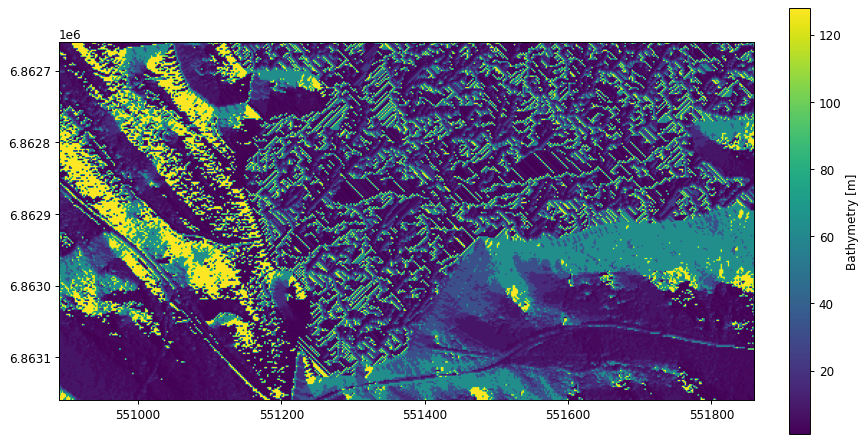

In [7]:
rasterit = []
for i in pnimet:
    rast = getWater(testitaso,i)
    rasterit.append(rast)

print (rasterit)
showRaster(rasterit[5])

## Leimikon valuma-alue

In [8]:
def calcFocal(in_array,etai):

    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    for i in range(0-etai,etai):
        for j in range(0-etai,etai):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=etai:
                ijlist.append((i,j))
    
    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t

In [9]:
def processRaster(input):
    
    rastOut = input[0:-4]+"hh.tif"
    rast = gdal.Open(input)
    
    rastb = rast.GetRasterBand(1)
    rastA = rastb.ReadAsArray()
    rastA = np.where(rastA>0,rastA,0)
    

    focal = calcFocal(rastA,2)
    #huip = focal - chmA
    huip = np.where(focal-rastA==2,1,0)
    #huip = np.where(huip>=5,huip*10,np.NaN)
    #print (huip)
    #print (np.max(huip))
    gdal_array.SaveArray(huip.astype("float32"),rastOut,"GTiff",rast)
    #gdal.Open(rastOut).GetRasterBand(1).SetNoDataValue(-9999)
    
    return rastOut

In [10]:
def my_callback(value):
    if not "%" in value:
        print(value)

In [11]:
def wbtBreachDepression(dem):
    
    #wbt = WhiteboxTools()
    output = os.path.dirname(os.path.realpath(dem))
    output = os.path.join(output,"dem_br.tif")
   
    wbt.breach_depressions(
        dem,
        output,
        max_depth=None,
        max_length=None,
        flat_increment=None,
        fill_pits=False,
        callback=my_callback
    )
    
    f = open(output)
    f.close()

    return output

In [12]:
def d8Pointer(dem):
    """
    slope = processing.run("gdal:aspect", 
                   {'INPUT':dem,
                    'BAND':1,
                    'TRIG_ANGLE':False,
                    'ZERO_FLAT':False,
                    'COMPUTE_EDGES':False,
                    'ZEVENBERGEN':False,
                    'OPTIONS':'',
                    'EXTRA':'',
                    'OUTPUT':'TEMPORARY_OUTPUT'})
    
    #s_arr = raster2Array(slope['OUTPUT'])
    #d8_arr = np.where(s_arr<=22.5,64,
                #np.where(s_arr<=67.5,128,0))
    #print(s_arr)
    #print(d8_arr)"""
    
    d8 = processing.run("grass7:r.stream.extract", 
                   {'elevation':dem,
                    'accumulation':None,
                    'depression':None,
                    'threshold':1,
                    'mexp':0,
                    'stream_length':0,
                    'd8cut':None,
                    'memory':1000,
                    'stream_raster':'TEMPORARY_OUTPUT',
                    'stream_vector':'TEMPORARY_OUTPUT',
                    'direction':'TEMPORARY_OUTPUT',
                    'GRASS_REGION_PARAMETER':None,
                    'GRASS_REGION_CELLSIZE_PARAMETER':0,
                    'GRASS_RASTER_FORMAT_OPT':'',
                    'GRASS_RASTER_FORMAT_META':'',
                    'GRASS_OUTPUT_TYPE_PARAMETER':0,
                    'GRASS_VECTOR_DSCO':'',
                    'GRASS_VECTOR_LCO':'',
                    'GRASS_VECTOR_EXPORT_NOCAT':False})
    
    
    return d8['direction']

In [13]:
def upstreamsValue(sr_taulukko,iy,ix,sarakkeet,rivit,arvot):
    cell_dict=collections.defaultdict(list)
    if rivit>ix+1 and sr_taulukko[ix+1,iy]==64:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix+1,iy])
        cell_dict["x"].append(ix+1)
        cell_dict["y"].append(iy)
                
    if rivit>ix+1 and sr_taulukko[ix+1,iy-1]==128:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix+1,iy-1])
        cell_dict["x"].append(ix+1)
        cell_dict["y"].append(iy-1)
                                   
    if sr_taulukko[ix,iy-1]==1:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix,iy-1])
        cell_dict["x"].append(ix)
        cell_dict["y"].append(iy-1)
        
    if sr_taulukko[ix-1,iy-1]==2:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix-1,iy-1])
        cell_dict["x"].append(ix-1)
        cell_dict["y"].append(iy-1)
     
    if sr_taulukko[ix-1,iy]==4:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix-1,iy])
        cell_dict["x"].append(ix-1)
        cell_dict["y"].append(iy)
        
    if sarakkeet>iy+1 and sr_taulukko[ix-1,iy+1]==8:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix-1,iy+1])
        cell_dict["x"].append(ix-1)
        cell_dict["y"].append(iy+1)
        
    if sarakkeet > iy+1 and sr_taulukko[ix,iy+1]==16:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix,iy+1])
        cell_dict["x"].append(ix)
        cell_dict["y"].append(iy+1)
      
    if rivit > ix+1 and sarakkeet > iy+1 and sr_taulukko[ix+1,iy+1]==32:
        cell_dict["tulos"].append(1)
        cell_dict["arvo"].append(arvot[ix+1,iy+1])
        cell_dict["x"].append(ix+1)
        cell_dict["y"].append(iy+1)
    
    return cell_dict

In [14]:
def watershed(d8,water):
    
    d8_arr = raster2Array(d8,1)
    water_arr = raster2Array(water,1)
    
    print(np.unique(d8_arr))
    
    tulostaulu=np.copy(d8_arr)
    tulostaulu = np.where(tulostaulu>=0,0,0)
    #tulostaulu[tulostaulu<130]=0
    
    #valumataulu=np.copy(tulostaulu)
    #valumataulu[valumataulu<=10]=0
    #purkupiste = np.copy(valumataulu)

    riv=int(str(np.shape(d8_arr)).split(',')[0].replace('(','').replace(',','').replace('L',''))
    sar=int(str(np.shape(d8_arr)).split(',')[1].replace(')','').replace(',','').replace('L',''))
    
    laskuri=0
    solut=water_arr.sum()
    prosenttilaskuri=10
    for (i,j) in np.ndenumerate(water_arr):
        if j > 0:
        
            if laskuri*100/solut>prosenttilaskuri:
                aika=str(strftime("%Y-%m-%d %H:%M:%S", localtime()))
                print(aika+": Laskettu "+str(prosenttilaskuri)+" % ...")
                prosenttilaskuri+=10
            x=int(str(i).split(' ')[0].replace('(','').replace(',','').replace('L',''))
            y=int(str(i).split(' ')[1].replace(')','').replace(',','').replace('L',''))
            xl = x
            yl = y
            #purkupiste[x,y]=laskuri
            #purkupistekoko[x,y]=count1
            count1 = 1
            arvo=1
            muisti=collections.defaultdict(list)
            #purkupiste[x,y]=laskuri
            while True:
                value = upstreamsValue(d8_arr,y,x,sar,riv)
                #print(value)
                if (len(value["x"])>0 or len(muisti["x"])>0):
                    for i in range(0,len(value["x"])):
                        muisti["x"].append(value["x"][i])
                        muisti["y"].append(value["y"][i])
                        muisti["tulos"].append(value["tulos"][i])
                        count1=count1+1
                    #valumataulu[x,y] = laskuri
                    x=int(muisti["x"][0])
                    y=int(muisti["y"][0])
                    arvo=muisti["tulos"][0]
                    #count2=count2+1
                    del muisti["x"][0]
                    del muisti["y"][0]
                    del muisti["tulos"][0]
                    tulostaulu[x,y]=arvo
                    #tt.write(str(count1)+","+str(x)+","+str(y)+","+str(arvo)+"\n")
                    #print(count1,ix,iy,arvo)
        
                else:
                    tulostaulu[x,y] = 1
                    break
                #count3=count3+1
            
            laskuri+=1
    tulos = array2raster(tulostaulu,d8)
    #tulos = arcpy.NumPyArrayToRaster(tulostaulu,pr_alavasen,pr_solukoko,value_to_nodata=10)
    #valuma=arcpy.NumPyArrayToRaster(valumataulu,pr_alavasen,pr_solukoko,value_to_nodata=0)
    #purku = arcpy.NumPyArrayToRaster(purkupiste,pr_alavasen,pr_solukoko,value_to_nodata=0)
    #tulos.save(tulosrasteri)
    #valuma.save(valumarasteri)
    #purku.save(purkurasteri)
    
    return tulos

In [15]:
rs = [1,2,3,4,5,6,7,8,9]
ls = [0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]
buf = [1,1,1,0,0,0,0,0,0,0]
leim = [1,1,1,1,1,1,1,0,0]

testD = [(rs[i],ls[i],buf[i],leim[i]) for i in range(len(rs))]
testD.reverse()

print (testD)

[(9, 0.1, 0, 0), (8, 0.2, 0, 0), (7, 0.3, 0, 1), (6, 0.4, 0, 1), (5, 0.5, 0, 1), (4, 0.4, 0, 1), (3, 0.3, 1, 1), (2, 0.2, 1, 1), (1, 0.1, 1, 1)]


In [16]:
#lst = np.array(testD)
lst = pd.DataFrame(testD)


#print (lst.where(lst[3]>0,inplace=False))
filt1 = lst[3]==1
filt2 = lst[2]==0

a = lst.where(filt1 & filt2, inplace = False)
print (a[0].sum())


22.0


In [17]:
b = np.array(lst[0])
print (np.cumsum(lst[0]))

0     9
1    17
2    24
3    30
4    35
5    39
6    42
7    44
8    45
Name: 0, dtype: int64


In [18]:
def calcMassFlux(elev,rusle,ls,water):
    mf = processing.run("saga:flowaccumulationrecursive", 
                   {'ELEVATION':elev,
                    'SINKROUTE':None,
                    'WEIGHTS':ls,
                    'FLOW':'TEMPORARY_OUTPUT',
                    'VAL_INPUT':None,
                    'VAL_MEAN':'TEMPORARY_OUTPUT',
                    'ACCU_MATERIAL':rusle,
                    'ACCU_TARGET':water,
                    'ACCU_TOTAL':'TEMPORARY_OUTPUT',
                    'ACCU_LEFT':'TEMPORARY_OUTPUT',
                    'ACCU_RIGHT':'TEMPORARY_OUTPUT',
                    'FLOW_UNIT':1,
                    'TARGETS':None,
                    'FLOW_LENGTH':'TEMPORARY_OUTPUT',
                    'WEIGHT_LOSS':'TEMPORARY_OUTPUT',
                    'METHOD':3,'CONVERGENCE':1.1,
                    'NO_NEGATIVES':True})
    
    return mf['ACCU_TOTAL']
    

In [ ]:
def mfWithBuffer(d8,water,buffer,ls,rusle):
    
    d8_arr = raster2Array(d8,1)
    water_arr = raster2Array(water,1)
    ls_arr = raster2Array(ls,1)
    
    tulostaulu=np.copy(d8_arr)
    tulostaulu = np.where(tulostaulu>=0,0,0)
    
    riv=int(str(np.shape(d8_arr)).split(',')[0].replace('(','').replace(',','').replace('L',''))
    sar=int(str(np.shape(d8_arr)).split(',')[1].replace(')','').replace(',','').replace('L',''))
    
    laskuri=0
    solut=water_arr.sum()
    prosenttilaskuri=10
    mf = []
    for (i,j) in np.ndenumerate(water_arr):
        if j > 0:
            ls_list = []
            if laskuri*100/solut>prosenttilaskuri:
                aika=str(strftime("%Y-%m-%d %H:%M:%S", localtime()))
                print(aika+": Laskettu "+str(prosenttilaskuri)+" % ...")
                prosenttilaskuri+=10
            x=int(str(i).split(' ')[0].replace('(','').replace(',','').replace('L',''))
            y=int(str(i).split(' ')[1].replace(')','').replace(',','').replace('L',''))
            xl = x
            yl = y
            #purkupiste[x,y]=laskuri
            #purkupistekoko[x,y]=count1
            count1 = 1
            arvo=1
            muisti=collections.defaultdict(list)
            #purkupiste[x,y]=laskuri
            while True:
                value = upstreamsValue(d8_arr,y,x,sar,riv,ls_arr)
                #print(value)
                if (len(value["x"])>0 or len(muisti["x"])>0):
                    for i in range(0,len(value["x"])):
                        muisti["x"].append(value["x"][i])
                        muisti["y"].append(value["y"][i])
                        muisti["tulos"].append(value["tulos"][i])
                        ls_list.append(value["arvo"][i])
                        count1=count1+1
                    #valumataulu[x,y] = laskuri
                    x=int(muisti["x"][0])
                    y=int(muisti["y"][0])
                    arvo=muisti["tulos"][0]
                    ls_list.append(value["arvo"][i])
                    #count2=count2+1
                    del muisti["x"][0]
                    del muisti["y"][0]
                    del muisti["tulos"][0]
                    tulostaulu[x,y]=arvo
                    
                else:
                    tulostaulu[x,y] = 1
                    ls_list.append(value["arvo"][i])
                    break
                #count3=count3+1
            mf.append(sum(ls_list))
            
            laskuri+=1
    tulos = array2raster(tulostaulu,d8)
    #tulos = arcpy.NumPyArrayToRaster(tulostaulu,pr_alavasen,pr_solukoko,value_to_nodata=10)
    #valuma=arcpy.NumPyArrayToRaster(valumataulu,pr_alavasen,pr_solukoko,value_to_nodata=0)
    #purku = arcpy.NumPyArrayToRaster(purkupiste,pr_alavasen,pr_solukoko,value_to_nodata=0)
    #tulos.save(tulosrasteri)
    #valuma.save(valumarasteri)
    #purku.save(purkurasteri)
    
    return tulos

In [ ]:
#sum (rusle) hakkuala on mitä lähdetään pienentämään
#(sum(rusle_h) + sum(rusle_b)) * ls

In [12]:
def wbtD8Pointer(dem):
    output = os.path.dirname(os.path.realpath(dem))
    output = os.path.join(output,"d8_br.tif")
    
    wbt.d8_pointer(
        dem, 
        output,
        esri_pntr = True,
        callback=my_callback
        )
    
    f = open(output)
    f.close()
    
    return output

In [22]:
def wbtWatershed(d8,pour_pts):
    output = os.path.dirname(os.path.realpath(d8))
    output = os.path.join(output,"watershed.tif")
    wbt.watershed(
        d8, 
        pour_pts, 
        output, 
        esri_pntr=True, 
        callback=my_callback
    )
    
    #f = open(output)
    #f.close()
    
    return output

In [13]:
def clipRaster(in_raster,band,clip_raster):
    
    output = os.path.dirname(os.path.realpath(in_raster))
    output = os.path.join(output,"clipped.tif")
    
    
    in_arr = raster2Array(in_raster,band)
    cl_arr = raster2Array(clip_raster,1)
    
    in_arr = np.where((cl_arr>0) & (in_arr>0),in_arr,0)
    
    gdal_array.SaveArray(in_arr.astype("float32"),output,"GTiff",in_raster)
    
    return output

In [14]:
def raster2Array(in_raster,band):
    rast = gdal.Open(in_raster)
    rastB = rast.GetRasterBand(band)
    rastA = rastB.ReadAsArray()

    return rastA

In [15]:
def rasterizeVector(in_layer,cells):
    #print ("jee")
    output = os.path.dirname(os.path.realpath(in_layer.sourceName()))
    output = os.path.join(output,"rasterized.tif")

    bbox = getBboxWmsFormat(in_layer)
    ss = bbox[0].split(',')
    extent = str(round(int(ss[0])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[3])+100,-1))+" ["+str(bbox[1])+"]"
    processing.run("gdal:rasterize",
                        {'INPUT':in_layer,
                        'FIELD':'',
                        'BURN':1,
                        'USE_Z':False,
                        'UNITS':1,
                        'WIDTH':cells,
                        'HEIGHT':cells,
                        'EXTENT':extent,
                        'NODATA':0,
                        'OPTIONS':'',
                        'DATA_TYPE':5,
                        'INIT':None,
                        'INVERT':False,
                        'EXTRA':'',
                        'OUTPUT':output})

    return output

In [35]:
def addMinimumDist(in_raster,distance,euclidean):
    
    output = os.path.dirname(os.path.realpath(in_raster))
    output = os.path.join(output,"dist_add.tif")
    
    inarr = raster2Array(in_raster,1)
    eucarr = raster2Array(euclidean,1)
    
    inarr = np.where((inarr>0)|((eucarr<=distance)&(eucarr>0)),1,0)
    
    gdal_array.SaveArray(inarr.astype("float32"),output,"GTiff",in_raster)
    
    return output

### Määritellään leimikon valuma-alue

[  1.   2.   4.   8.  16.  32.  64. 128.]
2023-02-15 14:28:02: Laskettu 10 % ...
2023-02-15 14:28:02: Laskettu 20 % ...
2023-02-15 14:28:02: Laskettu 30 % ...
2023-02-15 14:28:02: Laskettu 40 % ...
2023-02-15 14:28:02: Laskettu 50 % ...
2023-02-15 14:28:02: Laskettu 60 % ...
2023-02-15 14:28:02: Laskettu 70 % ...
2023-02-15 14:28:02: Laskettu 80 % ...
2023-02-15 14:28:02: Laskettu 90 % ...


C:\Users\mkesala\AppData\Local\Temp\ipykernel_9148\2452465168.py:3: ResourceWarning: unclosed file <_io.BufferedRandom name=5>
  tempd = tempd.name+'.tif'


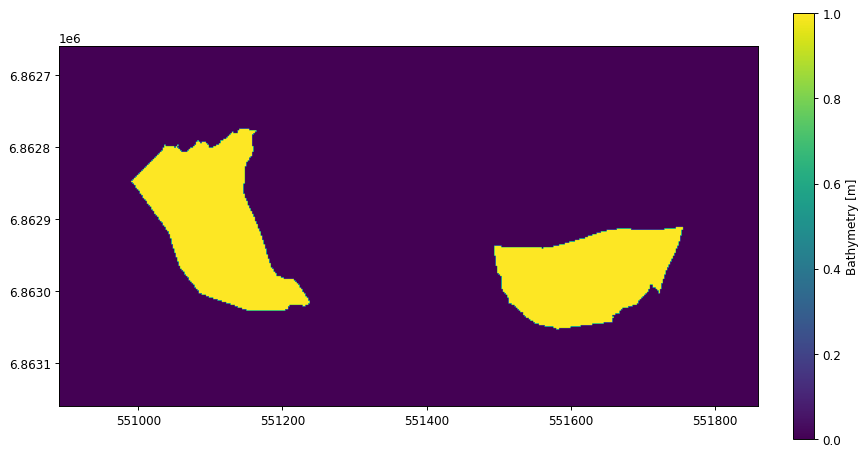

In [43]:
#dem_bd = wbtBreachDepression(rasterit[4]) #eheät valumat
#d8 = d8Pointer(dem_bd) #valunnan suunnat
vraster = processRaster(rasterit[3]) #vesistörajan määritys

leimraster = rasterizeVector(testitaso,2)
vrast_clip = clipRaster(vraster,1,leimraster) # rajataan leimikkoon
waters_leim = watershed(rasterit[5],vrast_clip)
leim_clip = clipRaster(waters_leim,1,leimraster)
euc_clip = clipRaster(rasterit[0],2,leimraster)
leim_clip = addMinimumDist(leim_clip,mindist,euc_clip)

showRaster(leim_clip)

## Määritellään suojakaistan laskennat

In [62]:
def loggingEffect(rusle,ls,zoneA,zoneB):

    logging = avoidedMassflux(rusle,ls,zoneA)
    #print (logging)
    bzone = avoidedMassflux(rusle,ls,zoneB)

    acc_max = logging[1] #accumulation max
    ret_max = logging[1] - logging[0] #retention max (accumalation max - natural accumulation)
    acc_nat = logging[0] #natural accumulation
    acc_bz = logging[1] - bzone[1] + bzone[0] #accumulation with buffer zone (accumulation max - accumulation max in buffer zone + accumulation in buffer zone)
    acc_res = logging[1]- (logging[1] - bzone[1] + bzone[0]) #reserved accumulation (accumulation max - accumulation with buffer zone)
    acc_add = ret_max - acc_res #added accumulation (retention max - reserved accumulation)
    #eff_res = round(100 -acc_add / acc_max * 100,1) #effect of reserved accumulation (%) (reserved accumulation / retention max * 100)
    eff_res = round(acc_nat / acc_bz *100,1) 
    #print (acc_max,ret_max,acc_nat,acc_bz,acc_res,acc_add,eff_res)
    return(acc_max,ret_max,acc_nat,acc_bz,acc_res,acc_add,eff_res)

In [45]:
def array2raster(in_array,map_raster):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.tif'
    
    gdal_array.SaveArray(in_array.astype("float32"),tempd,"GTiff",map_raster)

    return tempd

In [46]:
def avoidedMassflux(rusle,ls,zone):
    
    rusleA = raster2Array(rusle,1)
    rusleA = np.where(rusleA>0,rusleA,0.1)
    rusleA = rusleA / 1000
    lsA = raster2Array(ls,3)
    lsA = np.where(lsA>0,lsA,0.1)
    lsA = lsA/100*rusleA
    #print(rusleA-lsA/100)
    #zoneA = raster2Array(zone,1)
    sum_rusle = np.where(zone>0,rusleA,0)
    sum_ls = np.where(zone>0,lsA,0)
    rus = np.sum(sum_rusle)
    amf = np.sum(sum_ls)

    return amf,rus

In [47]:
def massfluxgraph(all):
    graafi = tempfile.TemporaryFile()
    graafi = graafi.name+'.png'

    plt.clf()
    plt.bar(all['area_ratio'],all['effect_bufferzone'])
    plt.xlabel("Area coverage (%)")
    plt.ylabel("Avoided massflux (%)")
    plt.savefig(graafi, dpi=150)
    
    return graafi

In [48]:
def raster2vector(in_rast,data):
    
    vectn = processing.run("gdal:polygonize", 
        {'INPUT':in_rast,
        'BAND':1,
        'FIELD':'DN',
        'EIGHT_CONNECTEDNESS':False,
        'EXTRA':'',
        'OUTPUT':"TEMPORARY_OUTPUT"})
    
    vect = QgsVectorLayer(vectn['OUTPUT'],"vyohyke","ogr")
    
    namelist = list(data.columns)
    for i in namelist:
        vect.dataProvider().addAttributes([QgsField(i,QVariant.Double)])
        vect.updateFields()
    
    with edit(vect):
        for feat in vect.getFeatures():
            if feat['DN'] == 0:
                vect.deleteFeature(feat.id())

            for i in namelist:
                datac = data[[i]]
                #print (datac.iloc[0,0])
                feat[i] = float(datac.iloc[0,0])
            
            geom = feat.geometry()
            buffer = geom.buffer(10, 5)
            buffer = buffer.buffer(-10,5)
            feat.setGeometry(buffer)

            vect.updateFeature(feat)
    
    return vect

In [60]:
def bufferZone(lzone,rasters,target):
    
    d1=[]
    arl =[]
    t = 0
    zraster = raster2Array(rasters[0],1)
    eucarr = raster2Array(rasters[0],2)
    #print (zraster)
    for i in range(0,105,5):
        zzone = []
        z=[]
        
        zzone = np.where(lzone==1,zraster,0)
        
        z = zzone[zzone>0]
        #print (z)
        z = np.percentile(z,i)
        #print (z,np.sum(zzone))
        
        zzone = np.where((zzone<z) & (lzone > 0) & (zzone>0),1,0)
        
        effect = loggingEffect(rasters[1],rasters[0],lzone,zzone)
        ar = round(float((np.sum(zzone) / np.sum(lzone) * 100)),1)
        d1.append(effect)
        arl.append(ar)
        print (effect)
        
        if (effect[6] > target and t == 0):
            t = 1
            effect_c = effect
            ar_c = ar
            zzone_c = zzone
    
    #print (d1)
    bzone = array2raster(zzone_c,rasters[1])
    
    
   
    
    dataset = {'massflux_max':[effect_c[0]],
                'retention_max':[effect_c[1]],
                'natural_massflux':[effect_c[2]],
                'massflux_bufferzone':[effect_c[3]],
                'massflux_reserved':[effect_c[4]],
                'massflux_added':[effect_c[5]],
                'effect_bufferzone':[effect_c[6]],
                'area_ratio':ar_c}
    
   
    dataset_all = {'massflux_max':[i[0] for i in d1],
                'retention_max':[i[1] for i in d1],
                'natural_massflux':[i[2] for i in d1],
                'massflux_bufferzone':[i[3] for i in d1],
                'massflux_reserved':[i[4] for i in d1],
                'massflux_added':[i[5] for i in d1],
                'effect_bufferzone':[i[6] for i in d1],
                'area_ratio':arl}

    df = pd.DataFrame(dataset)
    df_all = pd.DataFrame(dataset_all)

    fig = massfluxgraph(df_all)
    
    #return bzone
    res = raster2vector(bzone,df)
    #gpd.read_file(res.source(),layer=res.sourceName()).plot(ax=ax)

    return res,fig

### Lasketaan suojakaista

(2742.8135, 1757.4302, 985.38324, 2742.8135, 0.0, 1757.4302, 35.9)
(2742.8135, 1757.4302, 985.38324, 2637.8257, 104.98779, 1652.4424, 37.4)
(2742.8135, 1757.4302, 985.38324, 2508.865, 233.94849, 1523.4817, 39.3)
(2742.8135, 1757.4302, 985.38324, 2398.7847, 344.0288, 1413.4014, 41.1)
(2742.8135, 1757.4302, 985.38324, 2281.053, 461.7605, 1295.6697, 43.2)
(2742.8135, 1757.4302, 985.38324, 2166.417, 576.3965, 1181.0337, 45.5)
(2742.8135, 1757.4302, 985.38324, 2057.6846, 685.1289, 1072.3013, 47.9)
(2742.8135, 1757.4302, 985.38324, 1959.4834, 783.3301, 974.1001, 50.3)
(2742.8135, 1757.4302, 985.38324, 1852.8638, 889.9497, 867.48047, 53.2)
(2742.8135, 1757.4302, 985.38324, 1750.9834, 991.8301, 765.6001, 56.3)
(2742.8135, 1757.4302, 985.38324, 1645.5645, 1097.249, 660.18115, 59.9)
(2742.8135, 1757.4302, 985.38324, 1539.8284, 1202.9851, 554.44507, 64.0)
(2742.8135, 1757.4302, 985.38324, 1436.7039, 1306.1096, 451.32056, 68.6)
(2742.8135, 1757.4302, 985.38324, 1344.3726, 1398.4409, 358.98926, 73.

C:\Users\mkesala\AppData\Local\Temp\ipykernel_9148\2452465168.py:3: ResourceWarning: unclosed file <_io.BufferedRandom name=5>
  tempd = tempd.name+'.tif'


<AxesSubplot:>

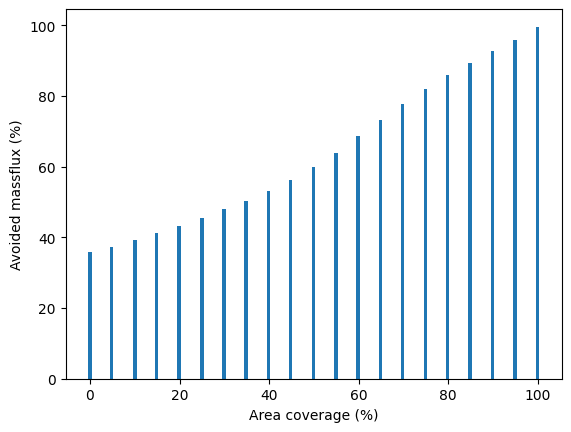

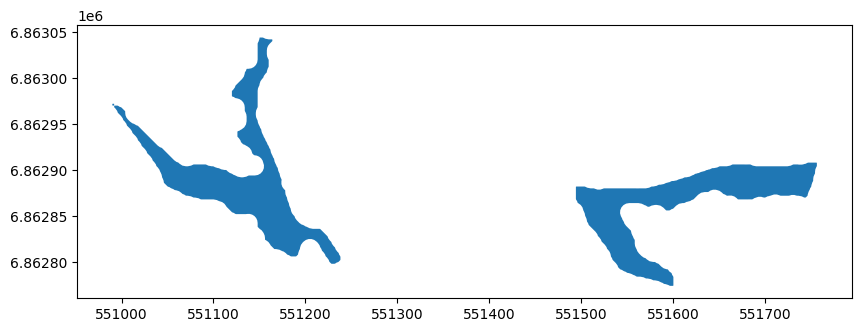

In [63]:
leim_clipA = raster2Array(leim_clip,1)

bz = bufferZone(leim_clipA,rasterit,50)

fig,ax = plt.subplots(figsize=(10,10))
gpd.read_file(bz[0].source(),layer="OUTPUT").plot(ax=ax)
#print (bz[0].source())


In [76]:
test = gpd.read_file(bz[0].source(),layer="OUTPUT")
print (test)

   DN  massflux_max  retention_max  natural_massflux  massflux_bufferzone  \
0   1   2764.088623    1776.797607        987.291077          2283.726318   
1   1   2764.088623    1776.797607        987.291077          2283.726318   
2   1   2764.088623    1776.797607        987.291077          2283.726318   

   massflux_reserved  massflux_added  effect_bufferzone  area_ratio  \
0         480.362305     1296.435303               53.1        19.8   
1         480.362305     1296.435303               53.1        19.8   
2         480.362305     1296.435303               53.1        19.8   

                                            geometry  
0  POLYGON ((550998.108 6862960.108, 550998.000 6...  
1  POLYGON ((551012.115 6862940.059, 551012.000 6...  
2  POLYGON ((551494.108 6862881.892, 551494.787 6...  
